In [11]:
# Reseteamos todas las variables del entorno
%reset
# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# **CONFIGURACION DEL ENTORNO**

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

sys.path

['/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code//SpeechEmotionRecognition',
 '',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [16]:
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
# FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'
# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
# RAVDESS_PATH = GPATH + 'data/RAVDESS/'
CAFEE_PATH = GPATH + 'data/CAFFE/'

# Maps
# EMOTION_MAP = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
# reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']

# **1. DATOS**

In [54]:
# Leemos CAFFE 
EMOTION_CAFFE_MAP = {'Joie':'happy', 'Tristesse':'sad', 'Colere':'angry','Degout':'disgust', 'Neutre':'neutral', 'Surprise':'surprise', 'Peur':'fear'}
emotion=[]
path = []

for folder in os.listdir(CAFEE_PATH):
  path_dir = os.listdir(CAFEE_PATH + folder)
  for filename in path_dir:
    str_path = CAFEE_PATH + str(folder) + '/' + str(filename)
    emotion.append(EMOTION_CAFFE_MAP[folder])
    path.append(str_path)
  
CAFFE_df = pd.DataFrame(columns=['emotion', 'path'])
CAFFE_df['emotion'] = emotion
CAFFE_df['path'] = path

class_distribution = CAFFE_df['emotion'].value_counts()
print( class_distribution )

fear        36
surprise    36
happy       36
sad         36
disgust     36
angry       36
neutral     36
Name: emotion, dtype: int64


In [24]:
# from src.SpeechDataProcess import SpeechDataProcess

# data = SpeechDataProcess('TESS', TESS_PATH)
# TESS_df = data.read()
# data = SpeechDataProcess('SAVEE', SAVEE_PATH)
# SAVEE_df = data.read()

In [92]:
emotion=[]
path = []
# reduced_values = ['a', 'd', 'h', 'sa', 'n']

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    label = filename[0]
    if filename[1].isalpha() : label = filename[0] + filename[1] 
    # Solo los valores reducidos
    # if label in reduced_values:
    path.append(str_path)
    if(label=='a'):
         emotion.append("angry")
    elif(label=='h'):
        emotion.append("happy")
    elif(label=='f'):
        emotion.append("fear")
    elif(label=='d'):
        emotion.append("disgust")
    elif(label=='n'):
        emotion.append('neutral')
    elif(label=='sa'):
        emotion.append("sad")
    elif(label=='su'):
        emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()
print( SAVEE_df['emotion'].value_counts() )

neutral     120
disgust      60
angry        60
fear         60
surprise     60
happy        60
sad          60
Name: emotion, dtype: int64


In [27]:
# Leemos TESS

emotion=[]
path = []
# reduced_values = ['angry', 'disgust', 'happy', 'sad', 'neutral']
for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)

    # Solo los valores reducidos
    # if label.lower() in reduced_values:
    path.append(str_path)
    emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
print( TESS_df['emotion'].value_counts() )
# TESS_df.sample(5)

Size of the dataset: 2800 

happy       400
neutral     400
fear        400
sad         400
surprise    400
disgust     400
angry       400
Name: emotion, dtype: int64


In [29]:
if len(TESS_df.emotion.unique()) == len(SAVEE_df.emotion.unique()) and len(TESS_df.emotion.unique()) == len(CAFFE_df.emotion.unique()):
  print("Todas las dimensiones son correctas")
else: print("Las dimensiones no son correctas")

Todas las dimensiones son correctas


# **2. EXTRACCION DE CARACTERISTICAS**

In [30]:
from src.MFCC import MFCC

### **2.1 DATOS DE ENTRENAMIENTO**

In [56]:
features_spectMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = "SAVEE")
features_spectMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = "TESS")

featuresMFCC_CAFFE = MFCC(df_data = CAFFE_df, dataset_name = "CAFFE")

#### **2.1.1 MFCC DE SAVEE**

In [33]:

features_path = FEATURES_PATH + 'reduced_german/'
if not os.path.exists(features_path + 'featuresMFCC_standard_SAVEE.pkl' and 
                      features_path + 'featuresMFCC_wn_SAVEE.pkl' and 
                      features_path +'featuresMFCC_shiftted_SAVEE.pk' and 
                      features_path + 'featuresMFCC_pitch_SAVEE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = 'SAVEE', outpath = features_path)
  featuresSAVEE_standard, featuresSAVEE_wn, featuresSAVEE_shiftted, featuresSAVEE_pitch = featuresMFCC_SAVEE.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_SAVEE.pkl', 'rb') as f:
    featuresSAVEE_pitch = pickle.load(f)

In [34]:
# Concatenamos con las clases
datasetSAVEE = pd.concat([SAVEE_df.emotion, pd.DataFrame(featuresSAVEE_standard['data'].values.tolist())],axis=1)
datasetSAVEE.head()

# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetSAVEE_augmented = pd.concat([datasetSAVEE.emotion, pd.DataFrame(featuresSAVEE_wn['data'].values.tolist(), )],axis=1)
datasetSAVEE_augmented = datasetSAVEE_augmented.append(datasetSAVEE, ignore_index = True)

#### **2.1.1 MFCC DE TESS**

In [35]:
features_path = FEATURES_PATH +  'reduced_german/'
if not os.path.exists(features_path + 'featuresMFCC_standard_TESS.pkl' and 
                      features_path + 'featuresMFCC_wn_TESS.pkl' and 
                      features_path +'featuresMFCC_shiftted_TESS.pk' and 
                      features_path + 'featuresMFCC_pitch_TESS.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = 'TESS', outpath = features_path)
  featuresTESS_standard, featuresTESS_wn, featuresTESS_shiftted, featuresTESS_pitch = featuresMFCC_TESS.read_features_dataAugmentation()

else:
  with open(features_path + 'featuresMFCC_standard_TESS.pkl', 'rb') as f:
    featuresTESS_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_TESS.pkl', 'rb') as f:
    featuresTESS_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_TESS.pkl', 'rb') as f:
    featuresTESS_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_TESS.pkl', 'rb') as f:
    featuresTESS_pitch = pickle.load(f)

In [36]:
# Concatenamos con sus clases
datasetTESS = pd.concat([TESS_df.emotion, pd.DataFrame(featuresTESS_standard['data'].values.tolist())],axis=1)
datasetTESS.head()

# Concatenamos la version aumentada de TESS con sus clases para usarlas luego
datasetTESS_augmented = pd.concat([datasetTESS.emotion, pd.DataFrame(featuresTESS_wn['data'].values.tolist(), )],axis=1)
datasetTESS_augmented = datasetTESS_augmented.append(datasetTESS, ignore_index = True)

In [37]:
print("SAVEE tiene {} filas y {} caracteristicas".format(datasetSAVEE.shape[0], datasetSAVEE.shape[1]-1))
print("TESS tiene {} filas y {} caracteristicas".format(datasetTESS.shape[0], datasetTESS.shape[1]-1))

SAVEE tiene 480 filas y 40 caracteristicas
TESS tiene 2800 filas y 40 caracteristicas


### **2.2 DATOS DE VALIDACION**

In [ ]:
features_path = FEATURES_PATH + 'test/caffe/'
if not os.path.exists(features_path + 'featuresMFCC_standard_CAFFE.pkl' and 
                      features_path + 'featuresMFCC_wn_CAFFE.pkl' and 
                      features_path +'featuresMFCC_shiftted_CAFFE.pk' and 
                      features_path + 'featuresMFCC_pitch_CAFFE.pkl'):
  print("Los archivos no existen. Se procede a crearlos...")
  featuresCAFFE_standard, featuresCAFFE_wn, featuresCAFFE_shiftted, featuresCAFFE_pitch = featuresMFCC_CAFFE.read_features_dataAugmentation(True, True)


 
else:
  with open(features_path + 'featuresMFCC_standard_CAFFE.pkl', 'rb') as f:
    featuresEMODB_standard = pickle.load(f)

  with open(features_path + 'featuresMFCC_wn_CAFFE.pkl', 'rb') as f:
    featuresEMODB_wn = pickle.load(f)

  with open(features_path + 'featuresMFCC_shiftted_CAFFE.pkl', 'rb') as f:
    featuresEMODB_shiftted = pickle.load(f)

  with open(features_path + 'featuresMFCC_pitch_CAFFE.pkl', 'rb') as f:
    featuresEMODB_pitch = pickle.load(f)


In [70]:
# Concatenamos con sus clases
datasetCAFFE = pd.concat([CAFFE_df.emotion, pd.DataFrame(featuresCAFFE_standard['data'].values.tolist())],axis=1)
datasetCAFFE.head()

# Concatenamos la version aumentada de EMODB con sus clases para usarlas luego
datasetCAFFE_wn = pd.concat([datasetCAFFE.emotion, pd.DataFrame(featuresCAFFE_wn['data'].values.tolist() )],axis=1)
datasetCAFFE_shiftted = pd.concat([datasetCAFFE.emotion, pd.DataFrame(featuresCAFFE_shiftted['data'].values.tolist() )],axis=1)
datasetCAFFE_wn = datasetCAFFE_wn.append(datasetCAFFE, ignore_index = True)
datasetCAFFE_augmented = datasetCAFFE_wn.append(datasetCAFFE_shiftted, ignore_index = True)

datasetCAFFE_augmented['emotion'].value_counts()

fear        108
happy       108
sad         108
disgust     108
angry       108
neutral     108
surprise    108
Name: emotion, dtype: int64

In [71]:
datasetCAFFE['emotion'].value_counts()

fear        36
surprise    36
happy       36
sad         36
disgust     36
angry       36
neutral     36
Name: emotion, dtype: int64

# **3. PROCESAMIENTO Y MODELO**

In [72]:
class ProcessData():
  
  def __init__(self):
    self.categorical_test_X = []
    self.categorical_test_Y = []

    self.categorical_train_X = []
    self.categorical_train_Y = []


  def __split_training_test(self, df, test_size_=0.25, n_splits_=1, train_size_=None):
    '''
    Divide el dataset en entrenamieto y test utilizando StratifiedShuffleSplit
    Aguments
    ---------
    Return
    -------
    '''
    X = df.drop(['emotion'], axis=1)
    Y = df.emotion
    test_train_stratified = StratifiedShuffleSplit(n_splits = n_splits_, test_size = test_size_, random_state=42)
    for train_index, test_index in test_train_stratified.split(X, Y):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    self.categorical_test_X = X_test
    self.categorical_test_Y = Y_test
    # print("Datos categoricos guardados: {} y {}".format(categorical_test_X.shape, categorical_test_Y.shape))
    self.categorical_train_X = X_train
    self.categorical_train_Y = Y_train

    return X_train, X_test, Y_train, Y_test


  def __data_normalization(self, val_train, val_test):
    '''
    Normaliza los datos mejorando la precision y la velocidad del proceso de entrenamiento.
    Explicacion: https://stackoverflow.com/questions/37232782/nan-loss-when-training-regression-network
    Aguments
    ---------
    Return
    -------
    '''
    mean = np.mean(val_train, axis=0)
    std = np.std(val_train, axis=0)

    X_train = (val_train - mean)/std
    X_test = (val_test - mean)/std

    return X_train, X_test


  def __data_to_categorical(self, x_train_norm, y_train, x_test_norm, y_test):
    '''
    Categoriza los datos y los formatea para su uso con keras. Asume que x_train y x_test estan normalizados.
    Aguments
    ---------
    Return
    -------
    '''
    # Preparamos los datos para la categorizacion
    x_train_norm = np.array(x_train_norm)
    y_train = np.array(y_train)
    x_test_norm = np.array(x_test_norm)
    y_test = np.array(y_test)

    # One hot encode 
    label_encoder = LabelEncoder()
    y_train = np_utils.to_categorical(label_encoder.fit_transform(y_train))
    y_test = np_utils.to_categorical(label_encoder.fit_transform(y_test))


    return x_train_norm, y_train, x_test_norm, y_test, label_encoder


  def dataset_splitted(self, dataframe, test_size = 0.25):
    '''
    Devuelve el dataset divido en entrenamiento y test

    '''
    X_train, X_test, Y_train, Y_test = self.__data_process(dataframe, test_size)

    return X_train, X_test, Y_train, Y_test




  def __data_process(self, features_df, test_size):
    '''
    Devuelve el conjunto de datos divido en entrenamiento test procesado correctamente

    '''
    # Division entre entrenamiento y test
    _X_train, _X_test, _Y_train, _Y_test =self.__split_training_test(features_df, test_size) 

    # 2. Normaliza los datos
    x_train_norm, x_test_norm = self.__data_normalization(_X_train, _X_test)
    # print(x_train_female_norm.shape)

    # 3. Categorización
    _X_train, Y_train, _X_test, Y_test, labels = self.__data_to_categorical(x_train_norm, _Y_train, x_test_norm, _Y_test)
    # print(labels_female.classes_)

    # 4. Cambio de Dimensión
    X_train = np.expand_dims(_X_train, axis=2)
    X_test = np.expand_dims(_X_test, axis=2)

    return X_train, X_test, Y_train, Y_test

  def get_categorical_classes(self, test=True, train=False):
    x = []
    y = []
    if test:
      x.extend(self.categorical_test_X)
      y.extend(self.categorical_test_Y)
      # return np.array(x), np.array()

    if train:  
      x.extend(self.categorical_train_X)
      y.extend(self.categorical_train_Y)
    
    return np.array(x), np.array(y)


In [73]:
def model_B(data, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
  model = Sequential()

  model.add(Conv1D(128, 5,padding='same',
                  input_shape=(data.shape[1],1),
                   activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=(8)))
  model.add(Conv1D(128, 5,padding='same',activity_regularizer=tf.keras.regularizers.l2(0.01)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(Flatten())
  # Numero de clases
  model.add(Dense(n_classes))
  model.add(Activation('softmax'))

  opt = keras.optimizers.RMSprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)
  model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

  return model

In [74]:
def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

# **4. PRUEBAS**

### **4.1 PREPARACION DE LOS DATOS**

In [75]:
# Concatenamos los conjuntos de datos que tendran lugar en esta prueba para el entrenamiento
savee_tess_dataset = datasetSAVEE.append(datasetTESS, ignore_index=True)
savee_tess_dataset = shuffle(savee_tess_dataset)
print("El nuevo dataframe tiene {} filas".format(len(savee_tess_dataset)))
savee_tess_dataset.head()

El nuevo dataframe tiene 3280 filas


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
1296,neutral,-346.743439,46.257217,-19.904709,23.656145,-26.195591,-2.470731,-5.774268,-22.716236,-14.024669,3.450024,-26.171709,11.702148,-13.102047,5.647641,-1.664282,-2.490969,-6.581133,0.290349,-12.671846,0.250927,-10.434886,-1.088341,-1.809598,-0.635389,7.027336,5.785295,8.106726,9.304555,8.635438,10.406310,10.489801,10.442215,2.763264,-0.617849,0.884238,3.294043,5.755008,1.777199,-0.190932,-1.516105
60,neutral,-392.128174,117.120865,43.270145,36.169529,-8.640635,-13.625765,7.417919,1.780767,-10.787390,-2.789846,-2.201869,-4.676147,-1.202137,3.065188,5.280735,3.714253,1.139675,1.217408,3.226415,-0.810324,-1.301249,2.351557,-1.333648,-2.768422,1.188715,-1.304180,0.670267,2.052615,-0.561679,1.261508,0.944361,0.589787,1.657864,0.909577,1.807193,2.948127,2.680573,3.330560,1.680348,-0.022830
1131,sad,-375.061066,67.924080,0.968672,29.938837,-7.333912,3.741281,-10.516407,-4.434489,-9.514871,9.867416,-20.328691,12.243356,-10.135386,6.516934,-4.715157,-4.280791,-2.340673,0.587938,-15.221974,0.638542,-6.335186,-6.403760,-8.060116,-2.498921,-6.283363,-1.737348,-3.908271,-0.274414,-3.312968,-1.103779,-8.236496,-3.505134,-6.323044,0.710998,8.386001,19.979618,28.861303,26.790926,20.746956,8.482252
1885,neutral,-449.259705,82.061203,14.857109,9.971005,-3.042331,3.278148,-22.234835,7.770267,-20.521667,5.208395,-17.983826,-1.593130,-3.836476,-2.609280,-2.243728,1.332934,-4.494612,16.271290,1.399130,2.334326,1.456316,0.352548,1.318584,4.477091,0.130437,4.231448,1.785036,7.172399,0.506472,3.368814,-0.503895,3.298434,6.083252,2.808897,4.251464,5.536074,6.516350,6.126743,7.664255,10.251328
399,fear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
savee_tess_dataset = savee_tess_dataset.dropna()
print(savee_tess_dataset['emotion'].value_counts())

neutral     490
fear        445
happy       445
sad         445
disgust     245
angry       245
surprise     45
Name: emotion, dtype: int64


Extraemos los datos con los que se entrenara el modelo

In [77]:
processed_savee_tess = ProcessData()
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(savee_tess_dataset)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (1770, 40, 1) y clases: (1770, 7)
Dimensiones del conjunto de test. Datos: (590, 40, 1) y clases: (590, 7)


### **4.2 ENTRENAMIENTO**

In [78]:
modelB = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history2_1 = modelB.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
56/56 [==============================] - 3s 22ms/step - loss: 2.9480 - accuracy: 0.2869 - val_loss: 2.5566 - val_accuracy: 0.3593
Epoch 2/100
56/56 [==============================] - 1s 12ms/step - loss: 2.5428 - accuracy: 0.3942 - val_loss: 2.3849 - val_accuracy: 0.4898
Epoch 3/100
56/56 [==============================] - 1s 13ms/step - loss: 2.3379 - accuracy: 0.4913 - val_loss: 2.2522 - val_accuracy: 0.5864
Epoch 4/100
56/56 [==============================] - 1s 13ms/step - loss: 2.1860 - accuracy: 0.5452 - val_loss: 2.1422 - val_accuracy: 0.6169
Epoch 5/100
56/56 [==============================] - 1s 12ms/step - loss: 2.0461 - accuracy: 0.6198 - val_loss: 2.0429 - val_accuracy: 0.6797
Epoch 6/100
56/56 [==============================] - 1s 12ms/step - loss: 1.9574 - accuracy: 0.6445 - val_loss: 1.9570 - val_accuracy: 0.6864
Epoch 7/100
56/56 [==============================] - 1s 13ms/step - loss: 1.8780 - accuracy: 0.6431 - val_loss: 1.8847 - val_accuracy: 0.7017
Epoch 

Gráfica para el rendimiento validado con el idioma del entrenamiento

19/19 [==============================] - 0s 4ms/step - loss: 0.7296 - accuracy: 0.8746
Loss: 0.7295927405357361 
Accuracy: 87.45762705802917%


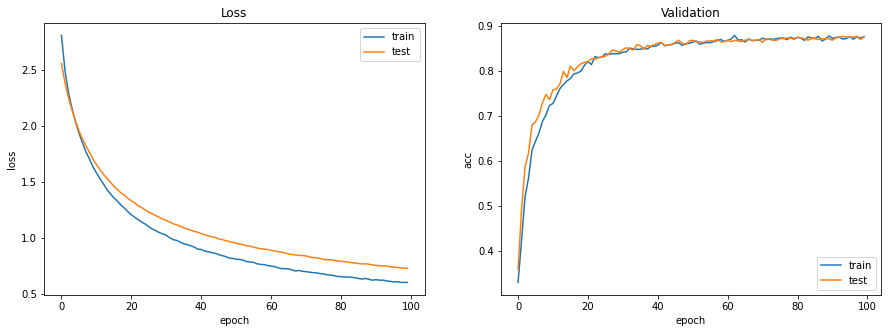

In [79]:
plot_loss_acc(model_history2_1)
# Evaluamos contra test
score = modelB.evaluate(X_test, Y_test, batch_size=32)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

### **EVALUACION CON FRANCES**

Procesamos los datos de validación

In [80]:
data_validation = ProcessData()
datasetCAFFE_dataset = shuffle(datasetCAFFE)
X_val, X_test_val, Y_val, Y_test_val = data_validation.dataset_splitted(datasetCAFFE_dataset, 0.1)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_val.shape, Y_val.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test_val.shape, Y_test_val.shape))

Dimensiones del conjunto de entrenamiento. Datos: (226, 40, 1) y clases: (226, 7)
Dimensiones del conjunto de test. Datos: (26, 40, 1) y clases: (26, 7)


In [81]:
from sklearn.metrics import classification_report

predicted_y = modelB.predict(X_val)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

y_true = np.argmax(Y_val, axis=1)

# Mapeo con el nombre de las clases
X, Y = data_validation.get_categorical_classes(False, True)
mapping = dict(zip(y_true, Y))

predicted_y = list(map(mapping.get, predicted_y))
y_true = list(map(mapping.get, y_true))

In [82]:
print(classification_report(y_true, predicted_y ))

              precision    recall  f1-score   support

       angry       0.15      0.73      0.25        33
     disgust       0.00      0.00      0.00        33
        fear       0.05      0.03      0.04        32
       happy       0.00      0.00      0.00        32
     neutral       0.00      0.00      0.00        32
         sad       0.29      0.16      0.20        32
    surprise       0.00      0.00      0.00        32

    accuracy                           0.13       226
   macro avg       0.07      0.13      0.07       226
weighted avg       0.07      0.13      0.07       226



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### **4.2.1 Data Augmentation**

In [83]:
augmented_savee_tess = datasetSAVEE_augmented.append(datasetTESS_augmented, ignore_index= True)
augmented_savee_tess = augmented_savee_tess.dropna()
augmented_savee_tess = shuffle(augmented_savee_tess)
print("La version aumentada de este dataset tiene {} instancias".format(len(augmented_savee_tess)))
augmented_savee_tess.head()

La version aumentada de este dataset tiene 4720 instancias


,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
1274,fear,-233.482812,19.592798,-9.753769,15.965651,-4.242658,-8.238877,-8.862900,-7.720066,-1.784305,-7.021385,-5.476115,4.812628,-7.947543,3.768140,-4.109947,-6.979204,-1.220824,-4.105950,-1.957542,2.921833,-1.777826,-0.603320,2.109478,2.597675,8.170783,10.549355,7.083703,2.932608,1.502613,2.026043,3.776193,3.015343,-1.926309,-4.161941,-1.041778,1.259276,1.556438,-1.592320,-1.497680,0.769800
3881,sad,-507.426819,87.369934,9.737194,15.324969,10.763605,14.204585,-19.149151,-6.385311,-18.740545,9.928338,-16.436771,7.442552,-5.204901,7.740821,-4.613317,-1.983178,-2.752147,1.179486,4.495923,-5.486284,7.827941,-1.892109,-4.917209,-0.191736,-5.453832,0.654424,-1.105066,1.840882,3.772954,6.333104,3.822912,9.936322,3.621293,1.160985,4.865374,6.090536,6.907810,13.016029,16.677855,14.116846
1246,fear,-244.458406,14.193050,-6.027799,10.670821,-6.049243,-2.074130,-12.082399,-11.162666,0.390776,-6.786481,-7.056849,5.516725,-6.607652,2.895226,-2.416999,-6.063467,2.323813,-2.053727,-1.444265,1.962829,-4.906537,-2.466643,0.582078,3.350003,6.246952,5.281061,1.602132,1.565047,4.735031,6.464108,4.561255,0.047649,-1.818788,0.578473,4.229783,4.433650,2.494815,-1.698881,-1.948071,-0.527880
2667,happy,-268.576117,25.331217,5.703066,3.598306,1.406172,0.594732,-4.071277,-0.553465,-5.781838,-2.856152,-2.390939,-0.420965,-2.375817,-1.404953,-0.529927,-1.648247,-0.728725,0.570395,-0.164500,-1.134042,0.696990,-0.662362,-2.625705,-2.084232,-2.375931,-1.906894,-0.895199,-0.628314,-0.320754,0.166848,1.146249,1.408893,2.686437,4.084537,4.987733,6.446978,6.898851,5.876100,6.240696,5.605552
1067,sad,-297.227154,17.900776,15.477428,11.263387,7.131616,2.870659,-2.121308,-4.323097,-5.160882,-3.779196,-4.230325,-3.122950,-2.839435,-1.385763,-0.421455,0.090239,1.357886,0.986848,-0.700801,-2.539346,-2.269511,-3.639245,-3.163509,-2.825503,-3.056307,-2.755070,-1.103982,-0.061195,0.490595,2.613079,3.737125,4.947713,5.588761,6.114044,6.490366,6.414140,6.705820,5.248552,4.028449,3.244820


In [84]:
print(augmented_savee_tess['emotion'].value_counts())

neutral     980
happy       890
fear        890
sad         890
disgust     490
angry       490
surprise     90
Name: emotion, dtype: int64


In [85]:
X_train, X_test, Y_train, Y_test = processed_savee_tess.dataset_splitted(augmented_savee_tess)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_train.shape, Y_train.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test.shape, Y_test.shape))

Dimensiones del conjunto de entrenamiento. Datos: (3540, 40, 1) y clases: (3540, 7)
Dimensiones del conjunto de test. Datos: (1180, 40, 1) y clases: (1180, 7)


In [86]:
data_validation = ProcessData()
X_val, X_test_val, Y_val, Y_test_val = data_validation.dataset_splitted(datasetCAFFE, 0.1)

print("Dimensiones del conjunto de entrenamiento. Datos: {} y clases: {}".format(X_val.shape, Y_val.shape))
print("Dimensiones del conjunto de test. Datos: {} y clases: {}".format(X_test_val.shape, Y_test_val.shape))

Dimensiones del conjunto de entrenamiento. Datos: (226, 40, 1) y clases: (226, 7)
Dimensiones del conjunto de test. Datos: (26, 40, 1) y clases: (26, 7)


In [87]:
model_aug2 = model_B(X_train, Y_train.shape[1])
# Callbacks para tratar el overfitting  
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)

model_history1_au = model_aug2.fit(X_train, Y_train,
                         batch_size=32,
                         epochs=100,
                         validation_data=(X_test, Y_test),
                         callbacks=[rlrp, es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
111/111 [==============================] - 3s 18ms/step - loss: 2.8507 - accuracy: 0.2720 - val_loss: 2.3900 - val_accuracy: 0.5102
Epoch 2/100
111/111 [==============================] - 1s 13ms/step - loss: 2.3290 - accuracy: 0.5157 - val_loss: 2.1618 - val_accuracy: 0.5924
Epoch 3/100
111/111 [==============================] - 1s 13ms/step - loss: 2.0841 - accuracy: 0.6044 - val_loss: 1.9937 - val_accuracy: 0.6585
Epoch 4/100
111/111 [==============================] - 1s 13ms/step - loss: 1.9040 - accuracy: 0.6449 - val_loss: 1.8648 - val_accuracy: 0.6771
Epoch 5/100
111/111 [==============================] - 1s 13ms/step - loss: 1.7576 - accuracy: 0.6796 - val_loss: 1.7573 - val_accuracy: 0.6958
Epoch 6/100
111/111 [==============================] - 1s 13ms/step - loss: 1.6426 - accuracy: 0.7127 - val_loss: 1.6683 - val_accuracy: 0.6983
Epoch 7/100
111/111 [==============================] - 2s 14ms/step - loss: 1.5669 - accuracy: 0.7237 - val_loss: 1.5936 - val_accuracy:

74/74 [==============================] - 0s 2ms/step - loss: 0.7191 - accuracy: 0.8441
Loss: 0.7190809845924377 
Accuracy: 84.40678119659424%


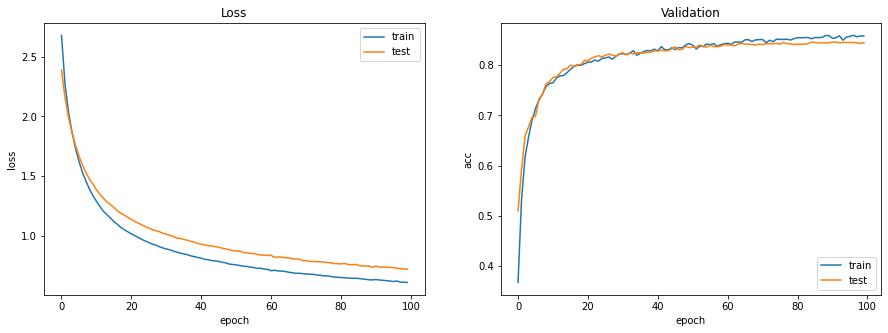

In [88]:
plot_loss_acc(model_history1_au)
# Evaluamos contra test
score = model_aug2.evaluate(X_test, Y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

In [89]:
from sklearn.metrics import classification_report

predicted_y = model_aug2.predict(X_val)
predicted_y = np.argmax(np.round(predicted_y), axis=1)

y_true = np.argmax(Y_val, axis=1)

# Mapeo con el nombre de las clases
X, Y = data_validation.get_categorical_classes(False, True)
mapping = dict(zip(y_true, Y))

predicted_y = list(map(mapping.get, predicted_y))
y_true = list(map(mapping.get, y_true))

In [90]:
print(classification_report(y_true, predicted_y ))

              precision    recall  f1-score   support

       angry       0.13      0.52      0.21        33
     disgust       0.00      0.00      0.00        33
        fear       0.10      0.09      0.10        32
       happy       0.00      0.00      0.00        32
     neutral       0.00      0.00      0.00        32
         sad       0.21      0.16      0.18        32
    surprise       0.00      0.00      0.00        32

    accuracy                           0.11       226
   macro avg       0.06      0.11      0.07       226
weighted avg       0.06      0.11      0.07       226



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


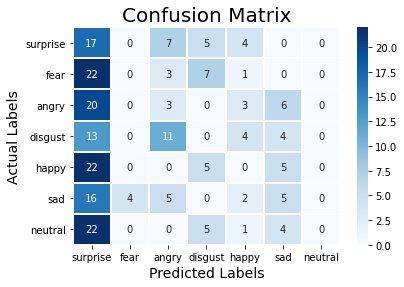

In [91]:
categories = mapping.values()
cm = confusion_matrix(y_true, predicted_y)
sns.heatmap(cm, linecolor='white', 
            cmap='Blues', 
            linewidth=1, 
            annot=True, 
            fmt='', 
            xticklabels=categories, 
            yticklabels=categories ) 

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
# modelB.save(GPATH + 'SpeechEmotionRecognition/models/model_TESS_SAVEE_05cnn1.h5')
# modelB.save(GPATH + 'SpeechEmotionRecognition/models/model_TESS_SAVEE_05cnn1_augmented.h5')